In [1]:
from tensorflow.keras.datasets import reuters
import pandas as pd
import numpy as np
import time

import os
from dotenv import load_dotenv
from sklearn.preprocessing import LabelEncoder

from utils.utils import TopicNeuralNet
pd.set_option('display.max_colwidth', None)

In [2]:
path = "./data/"

In [3]:
ls data

1.crypto_apps_reviews_raw.csv
1.crypto_category.txt
2.crypto_app_reviews_tagged.csv
3.tagged_reviews_sample.csv
4.tagged_reviews_sample_llm_verified.csv
4.tagged_reviews_sample_verified.csv
co.mona.android.csv
com.binance.dev.csv
com.bybit.app.csv
crypt_app_llm_tagged.csv
crypto_app_llm_tagged.csv
final_report_rubric_v2.pdf


In [4]:
df = pd.read_csv(path+"/4.tagged_reviews_sample_verified.csv")

In [5]:
hold_out_index = df["app"]== "com.binance.dev"

In [6]:
df_r = df.sample(df.shape[0] * 100, replace=True)

In [7]:
df_r.columns

Index(['reviewId', 'userName', 'userImage', 'content', 'score',
       'thumbsUpCount', 'reviewCreatedVersion', 'at', 'replyContent',
       'repliedAt', 'appVersion', 'app', 'gemini_llm_topic', 'correct',
       'human_labeled_topic', 'cause', 'corrected_topic'],
      dtype='object')

In [8]:
df_r["gemini_llm_topic"].value_counts()

gemini_llm_topic
Usability/UI/UX                     5139
Generic feedback                    4943
Reliability/Stability               3919
Account Management                  3704
Customer Support                    3541
Transaction Fees/Speed              3141
Features/Functionality              2519
Verification/KYC/AML Processes      1697
Security                             523
Educational Resources/Onboarding     408
Wallet Security/Integration          282
Privacy                               84
Name: count, dtype: int64

## Preprocessing

In [9]:
from collections import Counter
import spacy
import string
import nltk

In [10]:
nlp = spacy.load('en_core_web_sm')
#nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words("english")
stemmer = nltk.stem.PorterStemmer()

In [11]:
unwanted_pipes = ['ner', 'parser']

# Further remove stop words and take the lemma instead of token text.
def spacy_tokenizer(doc):
    with nlp.disable_pipes(*unwanted_pipes):
        return [t.lemma_ for t in nlp(doc) if \
            not t.is_punct and \
            not t.is_space and \
            not t.is_stop and \
            t.is_alpha] #only consider alphanumeric character

def nltk_tokenizer(doc):
    doc = doc.strip()
    doc = doc.lower()
    tokens = nltk.word_tokenize(doc)
    return [stemmer.stem(t) for t in tokens if \
        t not in string.punctuation and \
        t not in stopwords ] #only consider alphanumeric character

In [12]:
df_r["content_preprocessed"] = df_r["content"].apply(lambda x: " ".join(nltk_tokenizer(x)))

In [13]:
df_r = df_r.reset_index()

In [14]:
corpus_raw = []
corpus_lower = []
corpus_preprocessed = []
for i in range(df_r.shape[0]):
    corpus_raw.extend(df_r["content"][i].strip().split())
    corpus_lower.extend(df_r["content"][i].lower().strip().split())
    corpus_preprocessed.extend(df_r["content_preprocessed"][i].split())
    

In [15]:
counter_raw = Counter(corpus_raw)
counter_lower = Counter(corpus_lower)
counter_preprocessed = Counter(corpus_preprocessed)

In [16]:
counter_preprocessed.most_common(30)

[("n't", 13745),
 ('app', 13687),
 ("'s", 7532),
 ('use', 5976),
 ('account', 5173),
 ('get', 4667),
 ('money', 4649),
 ('crypto', 4476),
 ('coin', 3915),
 ('updat', 3800),
 ('good', 3528),
 ('ca', 3516),
 ('exchang', 3396),
 ('trade', 3386),
 ('work', 3303),
 ('fee', 3229),
 ('custom', 3210),
 ('binanc', 3186),
 ('card', 3062),
 ('servic', 3022),
 ('tri', 2923),
 ('time', 2885),
 ('``', 2836),
 ('bybit', 2785),
 ('pi', 2704),
 ('pleas', 2691),
 ("''", 2592),
 ('list', 2474),
 ("'m", 2449),
 ('one', 2444)]

In [17]:
30/len(counter_lower)

0.013380909901873328

In [18]:
counter_preprocessed.most_common(30)[1][1]/len(counter_preprocessed)

10.37680060652009

In [19]:
top_sum_raw = 0
top_sum_lower = 0
top_sum_preprocessed = 0

top_n = 30
for i in range(top_n):
    top_sum_raw += counter_raw.most_common(top_n)[i][1]
    top_sum_lower += counter_lower.most_common(top_n)[i][1]
    top_sum_preprocessed += counter_preprocessed.most_common(top_n)[i][1]
print(f"""
    Unique words for raw text:{len(counter_raw)}.
    Percentage of tokens concentrated in the top {top_n} words:{100*top_sum_raw / counter_raw.total()}
    """)

print(f"""
    Unique words for lower case text:{len(counter_lower)}.
    Percentage of tokens concentrated in the top {top_n} words:{100*top_sum_lower / counter_lower.total()}
    """)

print(f"""
    Unique words for Preprocessed text:{len(counter_preprocessed)}.
    Percentage of tokens concentrated in the top {top_n} words:{100*top_sum_preprocessed / counter_preprocessed.total()}
    """)


    Unique words for raw text:2508.
    Percentage of tokens concentrated in the top 30 words:30.85240318643546
    

    Unique words for lower case text:2242.
    Percentage of tokens concentrated in the top 30 words:33.69420001720929
    

    Unique words for Preprocessed text:1319.
    Percentage of tokens concentrated in the top 30 words:25.00073681252935
    


Why preprocess:
* Reduce number of tokens.
* Remove words that are very generic (the, 

# check: https://colab.research.google.com/drive/1y8tnFKQ_mW4CA0McZ-HJJoeheRL2j265
take the lemma: example of comments "Pi not listed", "They dont list pi", ideally we extract only "list"

## Train test split

In [20]:
from sklearn.model_selection import train_test_split

In [21]:
df_r.shape

(29900, 19)

In [22]:
X = df_r
y = df_r.gemini_llm_topic

In [23]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42)


#split text and labels
train_sentences = X_train.content_preprocessed.to_numpy()
train_labels = X_train.gemini_llm_topic.to_numpy()
test_sentences = X_test.content_preprocessed.to_numpy()
test_labels = y_test.to_numpy()

In [24]:
topic_model = TopicNeuralNet(X_train.content.to_numpy(),train_labels)
topic_model.fit(epochs=100, preprocess=True, bootstrap=False)

Model Initialized
Reviews have been preprocessed
Review Tokenizer Fitted
Reviews have transformed into a sequence
Label Tokenizer Fitterd
Labels have been encoded
Model Architecture set
Model Compiled
Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.0254 - loss: 145.5516 - val_accuracy: 0.1573 - val_loss: 18.3870
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.1027 - loss: 48.1726 - val_accuracy: 0.3503 - val_loss: 10.1361
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.1318 - loss: 30.0100 - val_accuracy: 0.3917 - val_loss: 7.2559
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.1725 - loss: 19.6536 - val_accuracy: 0.3895 - val_loss: 6.7101
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.1809 - loss: 13.2387 - val_accuracy: 0.3902 - val_loss: 6.7557
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2040 - loss: 9.9361 - val_accuracy: 0.2780 - val_loss: 7.0813
Epoch 7/100
15/15 ━━━━━━━━━━

In [26]:
topic_model.model.evaluate(topic_model.X_train_padded, topic_model.y_train)

748/748 ━━━━━━━━━━━━━━━━━━━━ 0s 453us/step - accuracy: 0.8910 - loss: 1.0618


[1.0533552169799805, 0.8923494815826416]

In [27]:
y_hat_test = topic_model.predict(X_test.content.to_numpy())

Reviews have transformed into a sequence
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 509us/step


In [28]:
pd.DataFrame({"y_test":test_labels, "y_hat_test":y_hat_test, "review": X_test.content})

,y_test,y_hat_test,review
15756,Generic feedback,Generic feedback,good
19617,Account Management,Usability/UI/UX,"The Google authentication is not working properly,I can't log in or reset my password it keeps say authentication code incorrect."
18973,Usability/UI/UX,Reliability/Stability,I don't understand my binance app it's not connecting to the Internet for some reasons I don't know. To open rewards hub it shows error not only that even some campaigns and some features on binance to make it worth one's time ain't loading.
16397,Reliability/Stability,Generic feedback,No évents ??
16366,Generic feedback,Generic feedback,ጥሩ
...,...,...,...
708,Account Management,Reliability/Stability,ITS A SCAM! They hide a way to get your money out. It's a whole process just to sell your crypto. Anytime I buy crypto it falls even when I wait hours looking at it drop every 5 mins. I've basically lost all of it because I can't get the rest out. Never again. EDIT: I got ahold of support and it's done nothing. There's no withdraw button and why do I have to link a bank account to get money back when they can take it ight off my debit card????
23587,Account Management,Generic feedback,can't log in please help
27362,Usability/UI/UX,Generic feedback,"Worst app , don't install"
20592,Usability/UI/UX,Generic feedback,"Worst app , don't install"


## Tokenize

In [29]:
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import OneHotEncoder

In [30]:
from collections import Counter

In [31]:
num_unique_words = len(counter_preprocessed)
print(num_unique_words)

1319


In [32]:
#vectorize a text corpus by turning each text into a sequence of integers
tokenizer = Tokenizer(num_words=num_unique_words)
tokenizer.fit_on_texts(train_sentences) #fit only to trainin

In [33]:
len(train_sentences)

23920

In [34]:
#vectorize the labels
le = LabelEncoder()
#le = OneHotEncoder()
le.fit(df_r["gemini_llm_topic"]) #fit only to trainin

LabelEncoder()

In [35]:
#each word has a unique index
word_index = tokenizer.word_index

In [36]:
train_sequences = tokenizer.texts_to_sequences(train_sentences)
test_sequences = tokenizer.texts_to_sequences(test_sentences)

In [107]:
y_train = le.transform(train_labels)
y_test = le.transform(test_labels)

In [108]:
print("Example sequence 1:")
print(f"Example sequence 2. Label: {y_train[10]}")
print(train_sentences[10])
print(train_sequences[10])
print(f"Example sequence 2. Label: {y_train[11]}")
print(train_sentences[11])
print(train_sequences[11])

Example sequence 1:
Example sequence 2. Label: 10
user 'm sent code use tell 's wrong code .... 'd love use exchang system could actual get
[32, 29, 171, 50, 4, 78, 3, 229, 50, 180, 66, 4, 15, 183, 46, 119, 6]
Example sequence 2. Label: 9
tri open crypto app keep lock ... app useless guess open anoth app crypto way get help ... put code send wo n't take .... tell live chat ca n't get app dummi
[21, 72, 8, 1, 52, 69, 1, 212, 544, 72, 87, 1, 8, 81, 6, 63, 117, 50, 102, 85, 2, 38, 78, 194, 151, 14, 2, 6, 1, 811]


As seen above, sequences can have different lengths since the sentences may contain a distinct number of words. We need all sequences to be of the same length, and for this we will use padding.

In [109]:
#Pad the sequences to have the same length
from tensorflow.keras.preprocessing.sequence import pad_sequences

#max number of words in a sequence
max_length = 255

train_padded = pad_sequences(train_sequences, maxlen= max_length, padding = "post", truncating = "post")
test_padded = pad_sequences(test_sequences, maxlen = max_length, padding = "post", truncating = "post")
train_padded.shape, test_padded.shape

((23920, 255), (5980, 255))

In [110]:
reverse_word_index = dict([(idx, word) for (word, idx) in word_index.items()])

In [111]:
def decode(sequence):
    return " ".join([reverse_word_index.get(idx, "?") for idx in sequence])

In [112]:
decoded_text = decode(train_sequences[10])

In [113]:
decoded_text

"user 'm sent code use tell 's wrong code 'd love use exchang system could actual get"

## Train model

In [114]:
num_classes = df_r["gemini_llm_topic"].nunique()

In [115]:
num_classes

12

In [116]:
df_r["gemini_llm_topic"].value_counts()

gemini_llm_topic
Usability/UI/UX                     5129
Generic feedback                    5059
Reliability/Stability               3868
Account Management                  3784
Customer Support                    3581
Transaction Fees/Speed              3061
Features/Functionality              2558
Verification/KYC/AML Processes      1566
Security                             488
Educational Resources/Onboarding     408
Wallet Security/Integration          305
Privacy                               93
Name: count, dtype: int64

In [117]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers

In [118]:
model = keras.Sequential([
layers.Dense(num_classes*20, 
             kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001), 
             #kernel_regularizer=regularizers.l2(0.002), 
             activation="relu"),
    
    layers.Dropout(0.3),
layers.Dense(num_classes*20, 
             kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001), 
             #kernel_regularizer=regularizers.l2(0.002), 
             activation="relu"),
    
    layers.Dropout(0.3),
layers.Dense(num_classes*20, 
             kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001), 
             #kernel_regularizer=regularizers.l2(0.002), 
             activation="relu"),
    
    #layers.Dropout(0.3),
    #layers.Dense(num_classes, activation="softmax")
])

desc_length = df_r["content_preprocessed"].apply(lambda x: len(x) )
max_length = max(desc_length)
model = keras.Sequential()
model.add(layers.Embedding(len(counter_preprocessed), 32))

model.add(layers.LSTM(64, dropout=0.1))
model.summary()

## Compile the model

In [47]:
#loss and optimizer
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optim = keras.optimizers.Adam(learning_rate=0.001)
metrics  = ["accuracy"]

In [48]:
model.compile(optimizer=optim, loss=loss, metrics=metrics)

In [49]:
#model.compile(optimizer="rmsprop",
#loss="sparse_categorical_crossentropy",
#metrics=["accuracy"])

In [50]:
len(train_padded)

23920

In [51]:
#validation set
x_val = train_padded[:50]
partial_x_train = train_padded[50:]
y_val = y_train[:50]
partial_y_train = y_train[50:]

In [52]:
history = model.fit(train_padded,
    y_train,
    epochs=100,
    batch_size=512,
    validation_split=0.7)

Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0710 - loss: 98.3443 - val_accuracy: 0.3969 - val_loss: 19.9551
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2782 - loss: 29.6089 - val_accuracy: 0.5807 - val_loss: 12.2247
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3734 - loss: 18.2993 - val_accuracy: 0.6665 - val_loss: 9.7845
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4243 - loss: 13.7744 - val_accuracy: 0.6865 - val_loss: 8.6469
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4786 - loss: 11.5351 - val_accuracy: 0.7065 - val_loss: 7.9183
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5148 - loss: 10.2312 - val_accuracy: 0.7468 - val_loss: 7.5001
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5393 - loss: 9.4775 - val_accuracy: 0.7499 - val_loss: 7.2273
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5827 - loss: 8.6880 - val_accu

In [53]:
#!pip install matplotlib

In [54]:
import matplotlib.pyplot as plt

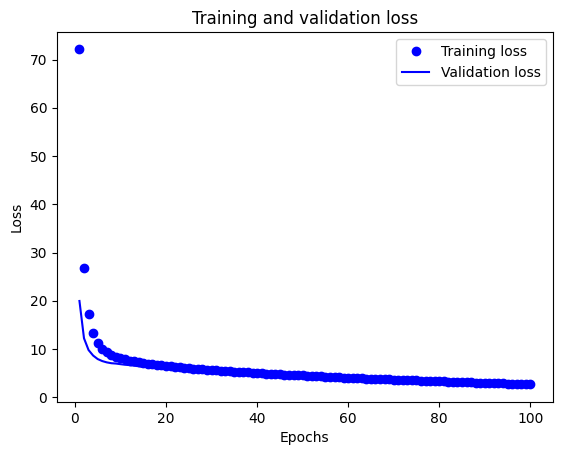

In [55]:
#plotting the training and validation loss
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [56]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [57]:
train_metric = 'accuracy'
val_metric = 'val_accuracy'

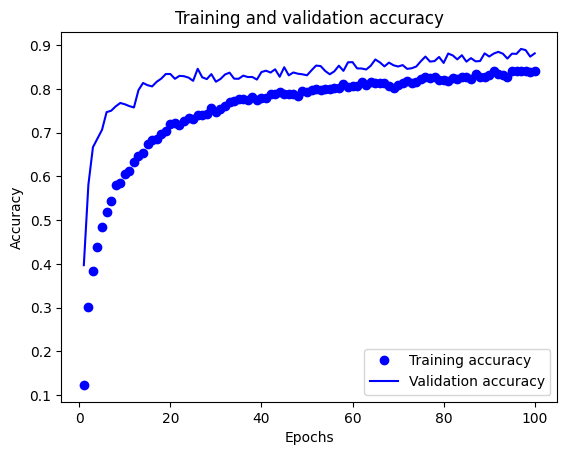

In [58]:
#plotting the training and validation accuracy
plt.clf()
acc = history.history[train_metric]
val_acc = history.history[val_metric]
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [59]:
model.evaluate(test_padded, y_test)

187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step - accuracy: 0.8839 - loss: 2.5498


[2.54620361328125, 0.884949803352356]

In [60]:
y_test

array([1, 3, 6, ..., 7, 6, 9])

In [61]:
predictions = model.predict(test_padded)

187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 544us/step


In [62]:
predictions[3]

array([2.9808077e+01, 3.9918060e+01, 3.1091949e+01, 3.0269651e+01,
       2.1377193e+01, 6.7104702e+00, 2.9723429e+01, 3.0930223e+01,
       2.0724628e+01, 6.1017746e+01, 2.8798426e+01, 2.1067057e+01,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 3.0974627e-02,
       3.5481399e-01, 0.0000000e+00, 9.4072646e-01, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 2.2290315e-01,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 1.6376004e+00, 3.0864038e+00,
       6.6070718e-01, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       4.2571807e-01, 0.0000000e+00, 3.2560199e-01, 5.4914016e-01,
       0.0000000e+00, 4.4371448e+00, 0.0000000e+00, 1.5220122e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 3.0785310e-01,
       0.0000000e+00, 0.0000000e+00, 1.2959983e+00, 0.0000000e+00,
       2.9228358e+00, 5.4021823e-01, 0.0000000e+00, 0.0000000e+00,
       4.2082202e-01, 0.0000000e+00, 0.0000000e+00, 0.0000000e

In [63]:
pred_list = []
for p in predictions:
   pred_list.append(p.argmax())

In [64]:
from sklearn.metrics import f1_score

In [65]:
f1_score(y_test, pred_list, average='micro')

0.8849498327759198

In [66]:
qa_df = pd.DataFrame({"text":X_test.content.to_numpy(), 
              "true_value":le.inverse_transform(y_test), 
              "predicted_value": le.inverse_transform(pred_list)})

In [67]:
dup_index = qa_df.duplicated()
qa_df = qa_df[~dup_index].copy()

In [68]:
for row in qa_df.to_dict(orient="records"):
    if row["predicted_value"]!= "generic feedback":
        print(row["text"])
        print("True value:",row["true_value"])
        print("Predicted value:", row["predicted_value"])
        print("***********************")

Worst customer service imaginable takes forever to get to a real service agent and the maker and taker fees are way to high, stay away this app is designed for amateurs that don't know any better and to take as much money away from you as possible.
True value: Customer Support
Predicted value: Customer Support
***********************
Is so Useless without Listening Pi network
True value: Features/Functionality
Predicted value: Features/Functionality
***********************
This company lied about burning coins in 2021 and now their CEO is addressing it's customers on social media like 3rd class citizens! Not to be trusted.
True value: Reliability/Stability
Predicted value: Reliability/Stability
***********************
Update: I don't need a lesson because I know how to get to it after hitting 500 buttons. But how is a person new to your app supposed to know how to search for a coin or stock? EVERY SITE ON EARTH HAS A SEARCH SYMBOI!m gonna 1 star this until they add a search symbol on t

## Predicting against holdout set